In [0]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [0]:
np.random.seed(42)
x_data = np.random.uniform(low=0, high=1, size=(1, 300))
v = np.random.uniform(low=-0.1, high=0.1, size=(1, 300))
y_data = np.sin(20*x_data) + (3 * x_data) + v

In [0]:
class NeuralNetwork:
    def __init__(self, data: np.ndarray, labels: np.ndarray, learning_rate=0.01):
        self.data = data
        self.labels = labels
        self.learning_rate = learning_rate

        self.num_samples = self.data.shape[1]

        np.random.seed(42)

        # Drawing samples from LeCun normal distribution
        # Source: https://arxiv.org/pdf/1706.02515.pdf

        self.w_1 = self.get_weights(size=(1, 24))
        self.b_1 = self.get_weights(size=(24, 1))

        self.w_2 = self.get_weights(size=(24, 1))
        self.b_2 = self.get_weights(size=(1, 1))

    @staticmethod
    def tan_inv(v):
        return 1 - np.tanh(v) ** 2

    @staticmethod
    def get_weights(size: tuple):
        # Drawing samples from LeCun normal distribution
        # Source: https://arxiv.org/pdf/1706.02515.pdf
        return np.random.normal(loc=0, scale=(1 / size[0]), size=size)

    def calc_mse(self):
        predictions = self.predict(self.data)
        mse = np.sum(((predictions - self.labels) ** 2) / self.num_samples)
        return mse

    def forward_pass(self, x_i):
        local_fields = list()
        activations = list()

        z_1 = self.w_1.T.dot(x_i) + self.b_1
        a_1 = np.tanh(z_1)

        local_fields.append(z_1)
        activations.append(a_1)

        z_2 = self.w_2.T.dot(a_1) + self.b_2
        a_2 = z_2

        local_fields.append(z_2)
        activations.append(a_2)

        return local_fields, activations

    def backward_pass(self, initial_delta, local_fields):
        delta_list = list()

        delta_list.append(self.w_2.dot(initial_delta) * self.tan_inv(local_fields[0]))
        delta_list.append(initial_delta)
        # delta_list.append(1)

        return delta_list

    def update_parameters(self, delta_list, activations, x_i):
        self.w_1 = self.w_1 - self.learning_rate * x_i.dot(delta_list[0].T)
        self.b_1 = self.b_1 - self.learning_rate * delta_list[0]

        self.w_2 = self.w_2 - self.learning_rate * activations[0].dot(delta_list[1])
        self.b_2 = self.b_2 - self.learning_rate * delta_list[1]

    def train(self):
        epoch_vs_mse = list()
        epoch_vs_mse.append([0, self.calc_mse()])
        epoch_cnt = 1
        while epoch_vs_mse[-1][1] >= 0.08:
            for x_i, d_i in zip(self.data[0], self.labels[0]):
                x_i = np.reshape(x_i, newshape=(1, 1))
                local_fields, activations = self.forward_pass(x_i)
                y_i = activations[-1][0, 0]
                delta_list = self.backward_pass(2*(y_i-d_i)/self.num_samples, local_fields)
                self.update_parameters(delta_list, activations, x_i)
            mse = self.calc_mse()
            if mse >= epoch_vs_mse[-1][1]:
                self.learning_rate = self.learning_rate * 0.9
            epoch_vs_mse.append([epoch_cnt, mse])
            epoch_cnt += 1

        return epoch_vs_mse

    def predict(self, input_data):
        return self.w_2.T.dot(np.tanh(self.w_1.T.dot(input_data) + self.b_1)) + self.b_2

In [0]:
nn_regressor = NeuralNetwork(x_data, y_data, learning_rate=6)
start_time = time.time()
epoch_vs_mse = nn_regressor.train()
end_time = time.time()
epoch_vs_mse = np.array(epoch_vs_mse)
print('Training finished with final Mean Squared Error of \
{:.4f} in {} epochs with a duration of {:.4f} seconds'.format(epoch_vs_mse[-1][1], epoch_vs_mse[-1][0], end_time-start_time))

Training finished with final Mean Squared Error of 0.0799 in 1441.0 epochs with a duration of 10.4790 seconds


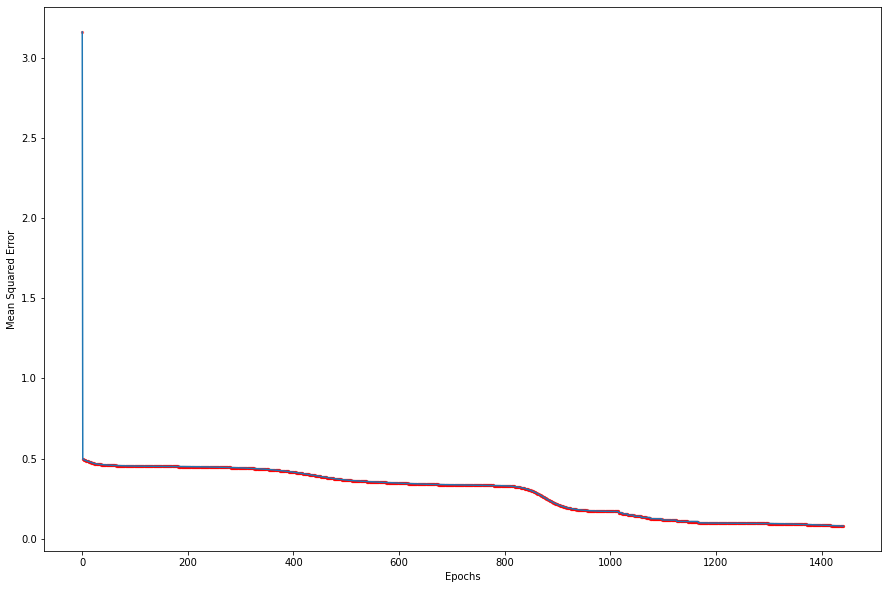

In [0]:
plt.figure(figsize=(15, 10))
plt.plot(epoch_vs_mse[:, 0], epoch_vs_mse[:, 1])
plt.scatter(epoch_vs_mse[:, 0], epoch_vs_mse[:, 1], s=5, c='red', alpha=0.5)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.show()

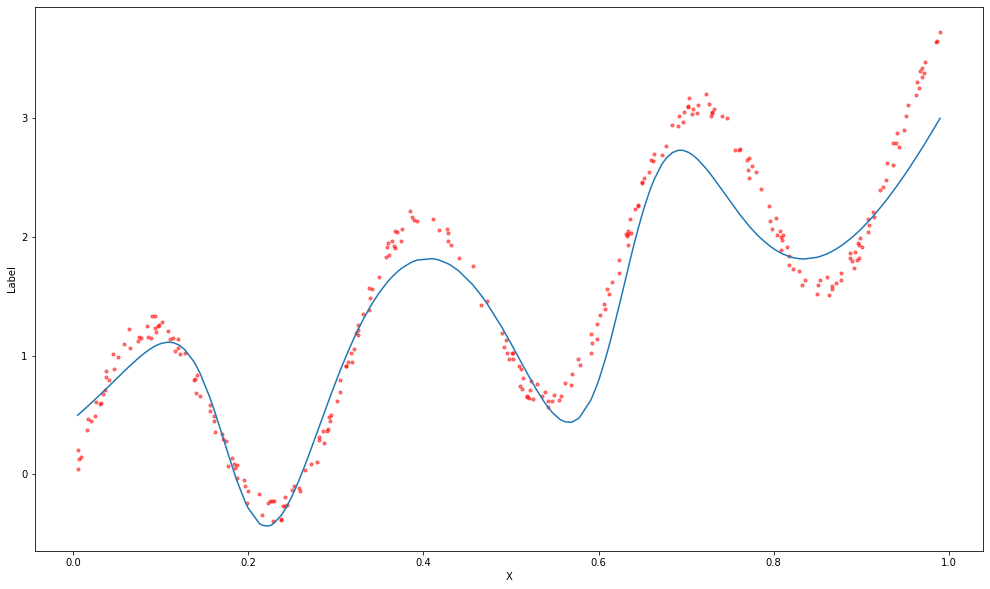

In [0]:
x_data_sorted = np.sort(x_data.copy())
predictions = nn_regressor.predict(x_data_sorted)
plt.figure(figsize=(17, 10))
plt.plot(x_data_sorted[0, :], predictions[0, :])
plt.scatter(x_data[0, :], y_data[0, :], s=10, c='red', alpha=0.5)
plt.ylabel('Label')
plt.xlabel('X')
plt.show()

## Pseudocode

while mse > 0.08:<br>
&emsp;for each training_example:<br>
&emsp;&emsp;for each layer $i$:<br>
&emsp;&emsp;&emsp;$v^i = {weights^i}^T \cdot activation^{i-1}$&emsp;{$activation^{i-1}$ for first layer is the train example}<br>
&emsp;&emsp;&emsp;$a^i = f^i(v^i)$<br>
&emsp;&emsp;for each layer $i$:<br>
&emsp;&emsp;&emsp;$\delta^i = (weights^{i+1} \cdot \delta^{i+1}) * {f^i}^{\prime}(v^i)$<br>
&emsp;&emsp;&emsp;$weights^i \leftarrow weights^i - \eta * (activation^{i-1} \cdot \delta^i)$<br>
&emsp;&emsp;&emsp;$bias^i \leftarrow bias^i - \eta * \delta^i$<br>
&emsp;mse = ${{1}\over{n}} \sum (d_i - y_i)^2$<br>
&emsp;if mse > mse_prev:<br>
&emsp;&emsp;$\eta \leftarrow \eta * decay\_factor$


### Where,<br>
$v^i \rightarrow$ Local field values of $i^{th}$ layer<br>
$w^i, b^i \rightarrow$ Weights and bias respectively for layer $i$<br>
$\delta^i \rightarrow$ Delta or error w.r.t layer $i$ (Derivative of cost function w.r.t to layer $i$)<br>
$f^i \rightarrow$ Activation function of layer $i$<br>
${f^i}^{\prime} \rightarrow$ Derivarive of activation function of layer $i$<br>
$a^i \rightarrow$ Activation of layer $i$<br>
$\eta \rightarrow$ Learning rate<br>
$\cdot \rightarrow$ Dot product<br>
$* \rightarrow$ Element-wise multiplication